# 04 Inverse problems

Active Subspaces can be applied to increase the efficiency of Hamiltonian Monte Carlo methods (HMC) when sampling from the posterior distribution of the inputs in the Bayesian framework [Constantine, Paul G. active subspaces: emerging ideas for dimension reduction in parameter studies](https://doi.org/10.1137/1.9781611973860).

Let us consider the following inverse problem: supposing that the inputs $\mathbf{x}$ are distributed according to a multivariate Gaussian distribution in $\mathcal{X}\subset\mathbb{R}^{m}$ we can compute the posterior distribution of $\mathbf{x}$ with the knowledge of a dataset $(\mathbf{x},\mathbf{y})$ where $\mathbf{y}$ are the targets obtained after the simulation $m(\mathbf{x})$ with the addition of a noise term

$$\large
\mathbf{y}\approx f(\mathbf{x})= m(\mathbf{x})+\mathcal{N}(0, \sigma I_{d}), \qquad m:\mathcal{X}\subset\mathbb{R}^{m}\rightarrow\mathbb{R}
$$

$$\large
\mathbf{x}\sim\mathcal{N}(0, I_{d}),\qquad f\sim\mathcal{N}(m(\mathbf{x}), \sigma I_{d})
$$

Sampling from the posterior distribution of the latent variables $\mathbf{x}$ with HMC is costly due to the evaluations of the model $m$

$$\large
p_{\text{posterior}}(\mathbf{x}|\mathbf{f}) = \frac{p_{\text{likelihood}}(\mathbf{f}|\mathbf{x})p_{\text{prior}}(\mathbf{x})}{p_{\text{marginal}}(\mathbf{f})}\propto p_{\text{likelihood}}(\mathbf{f}|\mathbf{x})p_{\text{prior}}(\mathbf{x})
$$

In order to avoid this we can approximate the model with a surrogate obtained employing the existence of an Active Subspace $g:\mathcal{X}_{\text{active}}\subset\mathbb{R}^{r}\rightarrow\mathbb{R}$ such that $g(\mathbf{s})\approx m(\mathbf{x})=m(W_{1}s+W_{2}t)$

$$\large
p_{\text{posterior}}(\mathbf{s}|\mathbf{g}) = \frac{p_{\text{likelihood}}(\mathbf{g}|\mathbf{s})p_{\text{prior}}(\mathbf{s})}{p_{\text{marginal}}(\mathbf{g})}\propto p_{\text{likelihood}}(\mathbf{g}|\mathbf{s})p_{\text{prior}}(\mathbf{s}), \qquad p_{prior}(\mathbf{t})=p_{posterior}(\mathbf{t})
$$

It is important to observe that in this way the inactive variable $\mathbf{z}$ has a multivariate Gaussian distribution and it is independent from the random variable $f$.

We use the library [Pyro](https://pyro.ai/) for probabilistic programming and [GPy](https://github.com/SheffieldML/GPy) for Gaussian process regression.

In [1]:
import torch
import GPy
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.infer import MCMC, NUTS, HMC
import pyro.optim

from athena.active import ActiveSubspaces

from data.torch_functions import sin_2d, radial

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Global parameters
n_samples = 100
input_dim = 5

Next we define the Likelihood (model) and the surrogate model (surrogate_model) built with active subspaces.

In [3]:
def model(f):
    """
    Likelihood p(f|x), the prior on the inputs is a multivariate Gaussian distribution.
    The model function of interest is f(X)=(X+1)^{2} where 1 is a vector of ones of the dimension of X.
    """
    x = pyro.sample(
        "input",
        pyro.distributions.MultivariateNormal(torch.zeros([input_dim]), torch.eye(input_dim)))
    mean = torch.norm(x + torch.ones(input_dim))**2
    eps = 0.1
    pyro.sample("outputs", pyro.distributions.Normal(mean, eps), obs=f)


def surrogate_model(f, gp):
    """
    Likelihood p(g|s), the prior on the inputs is a multivariate Gaussian distribution.
    The model function of interest is the response function g(S) designed with active subspaces.
    """
    y = pyro.sample("input", pyro.distributions.Normal(0, 1))
    mean = gp.predict(y.cpu().detach().numpy().reshape(-1, 1))[0]
    eps = 0.1
    pyro.sample("outputs", pyro.distributions.Normal(torch.Tensor(mean), eps), obs=f)

In [4]:
#generate inputs, outputs, gradients
dist_inputs = pyro.distributions.MultivariateNormal(torch.zeros([input_dim]),
                                                    torch.eye(input_dim))
x = dist_inputs(sample_shape=torch.Size([n_samples]))
x.requires_grad = True
f = radial(x + torch.ones(input_dim), generatrix=lambda x: x)
f.backward(gradient=torch.ones([n_samples]))
df = x.grad
print(df.shape, f.shape, x.shape, f.var())

torch.Size([100, 5]) torch.Size([100]) torch.Size([100, 5]) tensor(37.3575, grad_fn=<VarBackward0>)


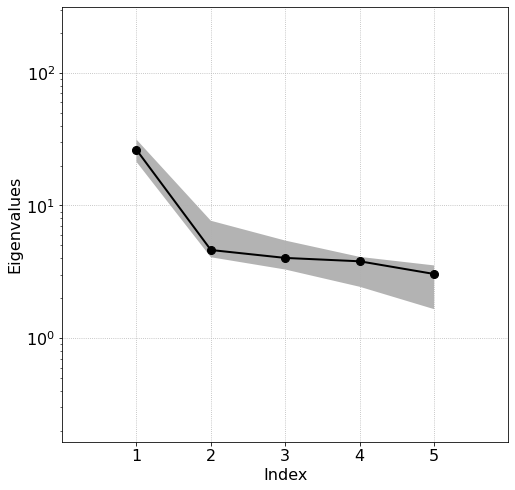

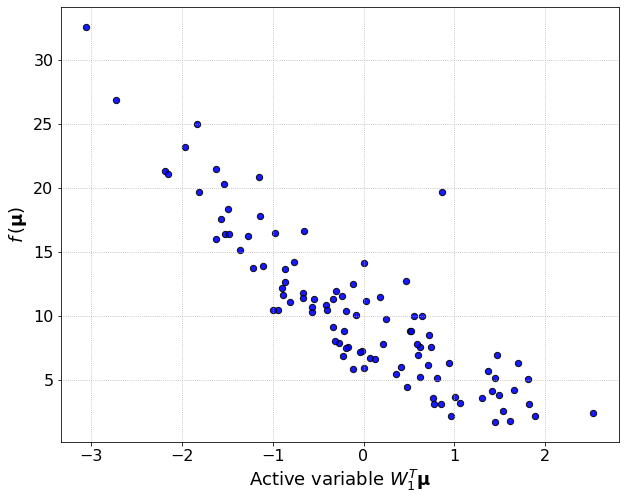

In [5]:
#search for an active subspace
ss = ActiveSubspaces()
ss.compute(gradients=df.cpu().detach().numpy(), method='exact')
ss.plot_eigenvalues()
ss.partition(1)
ss.plot_sufficient_summary(x.detach().numpy(), f.detach().numpy())

In [6]:
kernel = GPy.kern.RBF(input_dim=1, ARD=True)
gp = GPy.models.GPRegression(
    ss.forward(x.detach().numpy())[0],
    f.reshape(-1, 1).detach().numpy(), kernel)
gp.optimize_restarts(5, verbose=False)

Use No U-Turn Sampler (NUTS) Hamiltonian Monte Carlo to sample from the posterior of the original model.

In [7]:
#plain NUTS
num_chains = 1
num_samples = 100
kernel = NUTS(model)
mcmc = MCMC(kernel,
            num_samples=num_samples,
            warmup_steps=100,
            num_chains=num_chains)
mcmc.run(f)
mcmc.summary()
mcmc_samples = mcmc.get_samples(group_by_chain=True)
print(mcmc_samples.keys())
chains = mcmc_samples["input"]
print(chains.shape)

Sample: 100%|██████████| 200/200 [10:55,  3.28s/it, step size=2.24e-03, acc. prob=0.862]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  input[0]     -0.16      1.20     -0.14     -1.88      1.76     20.07      1.00
  input[1]      0.07      0.93      0.18     -1.13      1.80     29.50      1.01
  input[2]      0.04      0.77      0.04     -1.39      1.11     80.03      0.99
  input[3]     -0.01      1.02      0.06     -1.64      1.72     27.04      0.99
  input[4]      0.41      0.78      0.50     -0.96      1.43     31.33      1.00

Number of divergences: 0
dict_keys(['input'])
torch.Size([1, 100, 5])


Show the probablity posterior distribution of each inputs' component (input_dim).

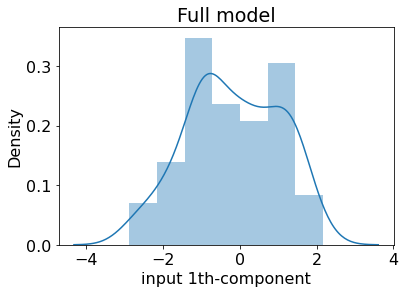

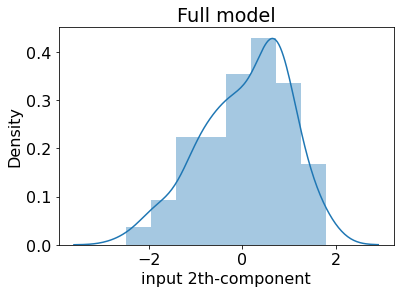

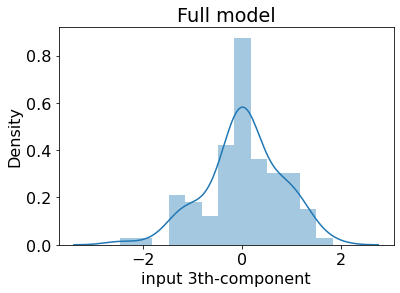

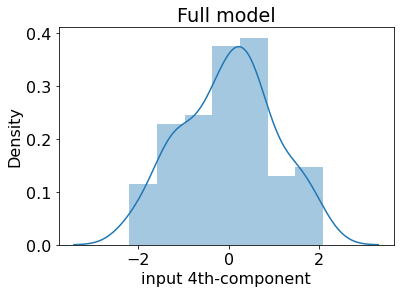

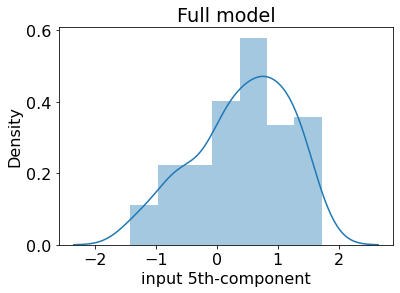

In [8]:
for i in range(5):    
    sns.distplot(mcmc_samples['input'][:, :, i])
    plt.title("Full model")
    plt.xlabel("input {}th-component".format(i+1))
    plt.show()

Posterior samples of the active variable from original model

-0.13822784301212035


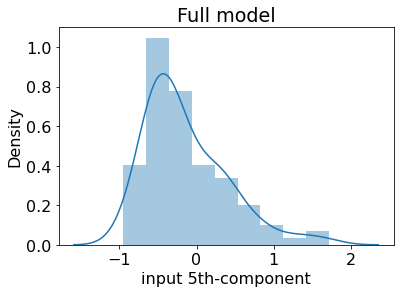

In [9]:
print(ss.forward(chains[0])[0].mean())
sns.distplot(ss.forward(chains[0])[0])
plt.title("Full model")
plt.xlabel("input {}th-component".format(i+1))
plt.show()

Use No U-Turn Sampler (NUTS) Hamiltonian Monte Carlo to sample from the posterior of the original model.

In [10]:
#AS NUTS
skernel = NUTS(surrogate_model)
smcmc = MCMC(skernel,
             num_samples=num_samples,
             warmup_steps=100,
             num_chains=num_chains)
smcmc.run(f, gp)
smcmc.summary()

smcmc_samples = smcmc.get_samples(group_by_chain=True)
print(smcmc_samples.keys())
chains = smcmc_samples["input"]
print(chains.shape)

Sample: 100%|██████████| 200/200 [04:28,  1.34s/it, step size=4.62e-04, acc. prob=0.773]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     input     -0.32      0.00     -0.32     -0.33     -0.32     17.84      1.03

Number of divergences: 0
dict_keys(['input'])
torch.Size([1, 100])


Show the probablity posterior distribution of the only (active) component.

tensor(-0.3224)


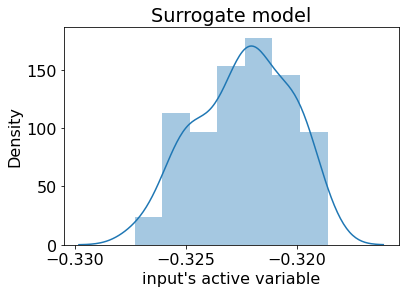

In [11]:
print(chains[0].mean())
sns.distplot(smcmc_samples['input'])
plt.title("Surrogate model")
plt.xlabel("input's active variable")
plt.show()

### Remarks

why is it crucial that the input distribution is a multivariate Gaussian and that the covariance matrix is $I_{d}$? For example can this procedure be extended for a pair of conjugate distributions like the Beta and the Binomial distribution?

This original formulation of ASMH results in a biased sample. Schuster, Ingmar, Paul G. Constantine, and T. J. Sullivan. "Exact active subspace Metropolis-Hastings, with applications to the Lorenz-96 system." arXiv preprint arXiv:1712.02749 (2017).